In [9]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import RoutingClient
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth
from obspy import signal
from obspy import read
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
import pandas as pd
from obspy.clients.fdsn.header import FDSNNoDataException
from scipy.signal import savgol_filter

import folium
import numpy as np
import branca.colormap as cm

from obspy import Stream
from matplotlib.colors import LogNorm

import pandas as pd

Dtmin_Noise=-25
Dtmax_Noise=-5
Dtmin_Pn=-5.
Dtmax_Pn=10.
Dtmin_Sn=-5.
Dtmax_Sn=10.

vLg_max=3.5
vLg_min=3.1
vLg=0.5*(vLg_max+vLg_min)
vPg_max=6.2
vPg_min=5.2
vPg=0.5*(vPg_max+vPg_min)
print(vPg)
#vPg=6.

tminCoda=300.
tmaxCoda=320.

5.7


In [2]:
from new_functions import get_data2, big_downloader2, calc_amps, plot_stations_amps, plot_record_section

/home/schreinl/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To do: 
- plot the enevelopes

<class 'numpy.ndarray'>


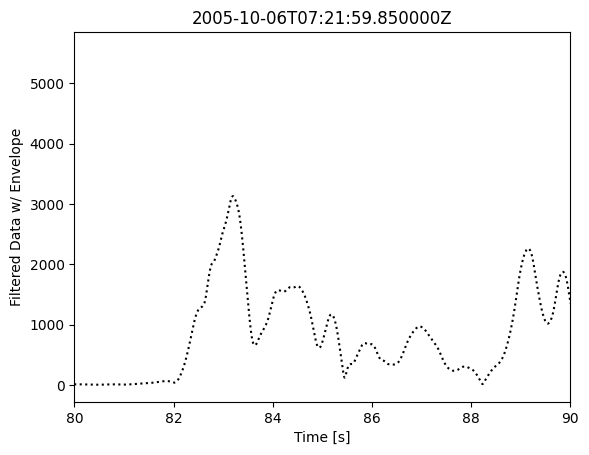

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
import obspy.signal


st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
data = st[0].data
npts = st[0].stats.npts
samprate = st[0].stats.sampling_rate

# Filtering the Stream object
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

# Envelope of filtered data
data_envelope = obspy.signal.filter.envelope(st_filt[0].data)
print(type(data_envelope))

# The plotting, plain matplotlib
t = np.arange(0, npts / samprate, 1 / samprate)
#plt.plot(t, st_filt[0].data, 'k')
plt.plot(t, data_envelope, 'k:')
plt.title(st[0].stats.starttime)
plt.ylabel('Filtered Data w/ Envelope')
plt.xlabel('Time [s]')
plt.xlim(80, 90)
plt.show()

#### Choose large earthquakes


In [3]:

catalogue_5 = pd.read_csv('/home/schreinl/Stage/Data/eq_4_france.csv')
catalogue_5 = catalogue_5[catalogue_5['mag'] >= 4.8].reset_index(drop=True)
print(len(catalogue_5))
carte = folium.Map([45, 7], zoom_start=5)

for _, row in catalogue_5.iterrows():
    infos = f"{row['time']} ({row['latitude']}, {row['longitude']}) {row['mag']} m"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        tooltip=infos,
        fill=True,
        fill_opacity=1.0,
        radius=4,
    ).add_to(carte)

carte


33


In [4]:
datacenters =['RESIF','ODC','ETH','INGV','GEOFON', 'IRIS', 'ICGC'] #'BGR'
directory='/home/schreinl/Stage/Data/'
distmin=1.9
distmax=10.
start = UTCDateTime(catalogue_5['time'][1])
end = start + 700
eq_lon = float(row['longitude'])
eq_lat = float(row['latitude'])
st_all, stations_all, plot = big_downloader2(datacenters, start, end, eq_lon, eq_lat, distmin, distmax, directory, plot=False)
time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")


Earthquake at 2023-06-16T16:38:28.069000Z with magnitude 4.8


Processing stations of ICGC: 100%|██████████| 25/25 [00:00<00:00, 25.65it/s]


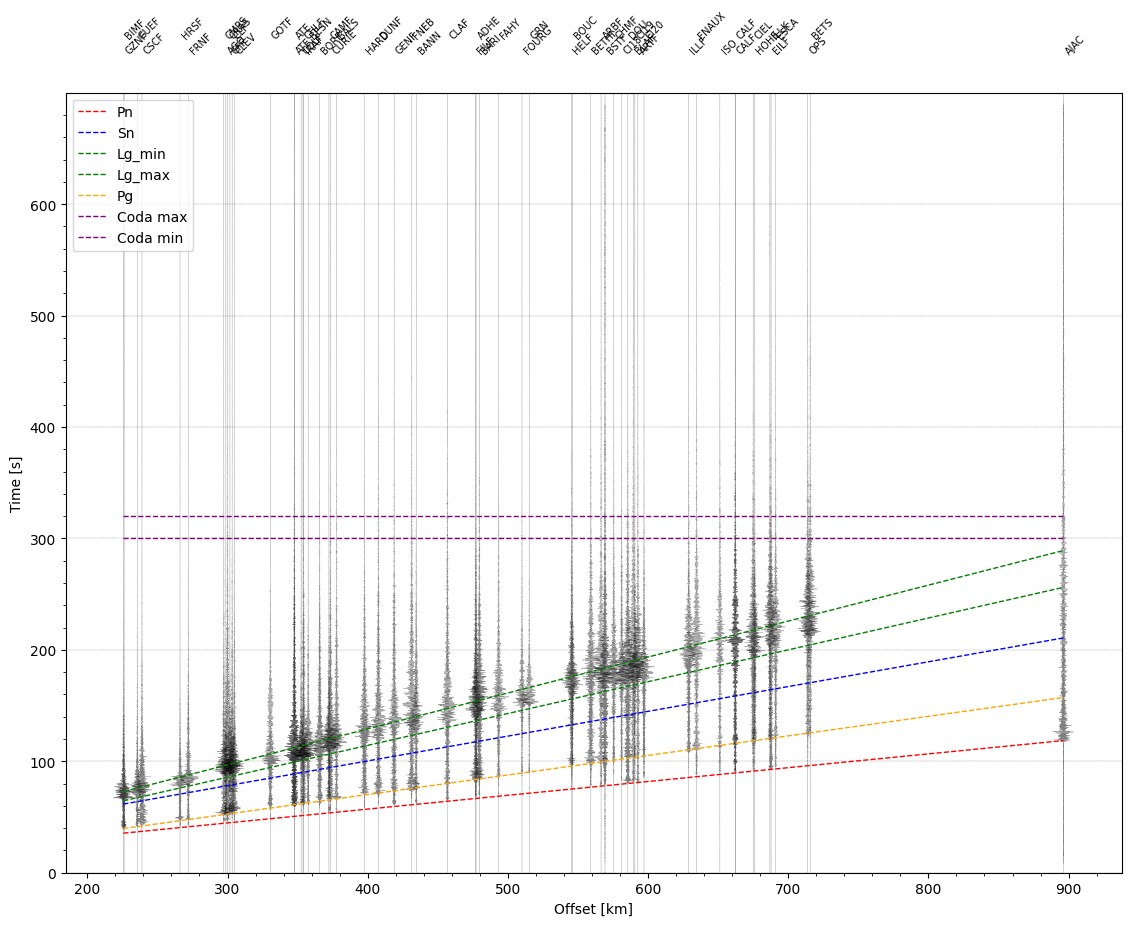

In [5]:
st_plot_filt_all=st_all.copy()
fmin=1
fmax=5
st_plot_filt_all.filter("bandpass", freqmin=fmin, freqmax=fmax)


plot, st_Lg0 = plot_record_section(st_plot_filt_all[0:60], stations_all[0:60], eq_lat, 
eq_lon, start, tracehodo=True, v_Lg_min=vLg_min, v_Lg_max=vLg_max, 
v_Pg=vPg)

In [6]:
print(len(st_plot_filt_all))

721


Choose now one station for a large event, plot the envelope and find the linear regime in the decay.
Then several stations can be plotted, the ratio and the coda amplitude ratio.


In [7]:
import obspy
from scipy.fftpack import hilbert
import numpy as np
#from obspy.signal.filter import envelope
from scipy.signal import resample


def envelope(data):
    hilb = hilbert(data)
    data = (data ** 2 + hilb ** 2) ** 0.5
    return data

st_envelope = obspy.Stream()
smallest = 7000
for tr in st_plot_filt_all:
    data_envelope = envelope(tr.data)
    npts = tr.stats.npts
    if npts >= smallest:
        samprate = tr.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)
        tr_envelope = obspy.Trace(data=data_envelope, header=tr.stats)
        #data_resampled = resample(tr_envelope.data, 10000)
        #tr_resampled = obspy.Trace(data=data_resampled, header=tr.stats)
        st_envelope.append(tr_envelope)
#st_envelope.write(f'/home/schreinl/Stage/Data/Envelopes/{time_string}_envelopes.mseed')





In [166]:
print(st_envelope[1].stats.station) #CI19 good for La Rochelle event

CI19


1


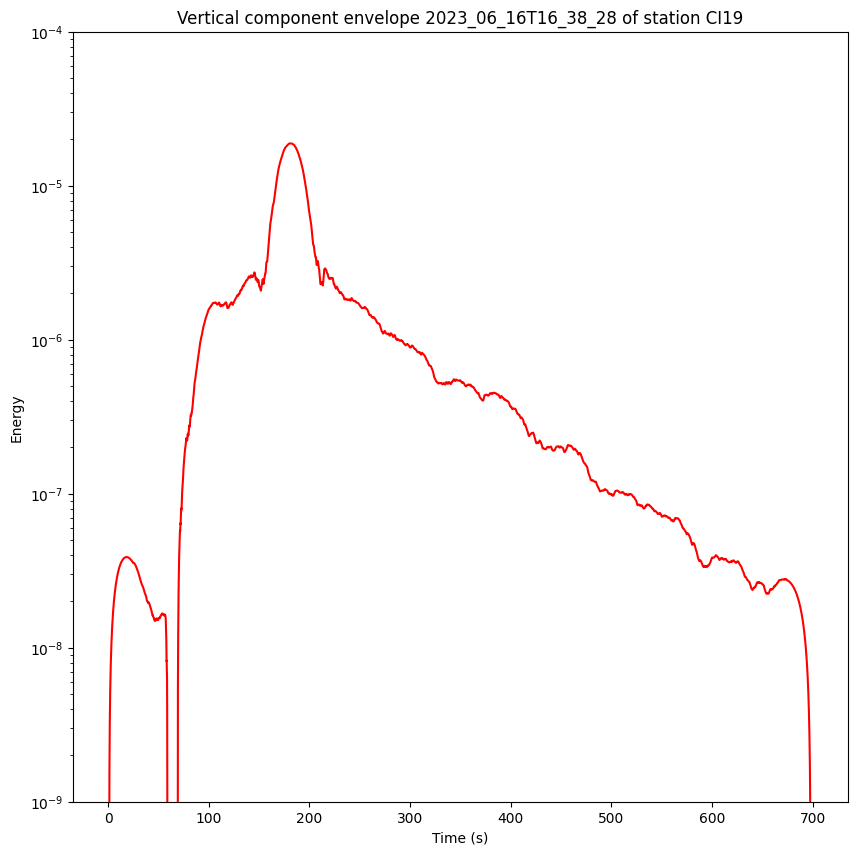

In [10]:
station = "CI19"
plt.figure(figsize=(10,10))
for i,tr in enumerate(st_envelope):
    if tr.stats.station == station:
        print(i)
        npts = len(tr.data)
        samprate = tr.stats.sampling_rate #10000/700 
        t = np.arange(0, npts / samprate, 1 / samprate)

        #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
        
        window_length = 50*samprate #min(2000, npts)
        if window_length % 2 == 0:
            window_length -= 1
        yhat = savgol_filter(tr.data, int(window_length), 3) 
        t = t[:len(yhat)]
        plt.title(f"Vertical component envelope {time_string} of station {station}")
        plt.ylabel("Energy")
        plt.xlabel("Time (s)")
        #plt.semilogy(t,st_envelope[i])
        plt.semilogy(t,yhat, color='red')
        plt.ylim([1e-9,1e-4])
        #plt.xlim([100,350])
plt.show()


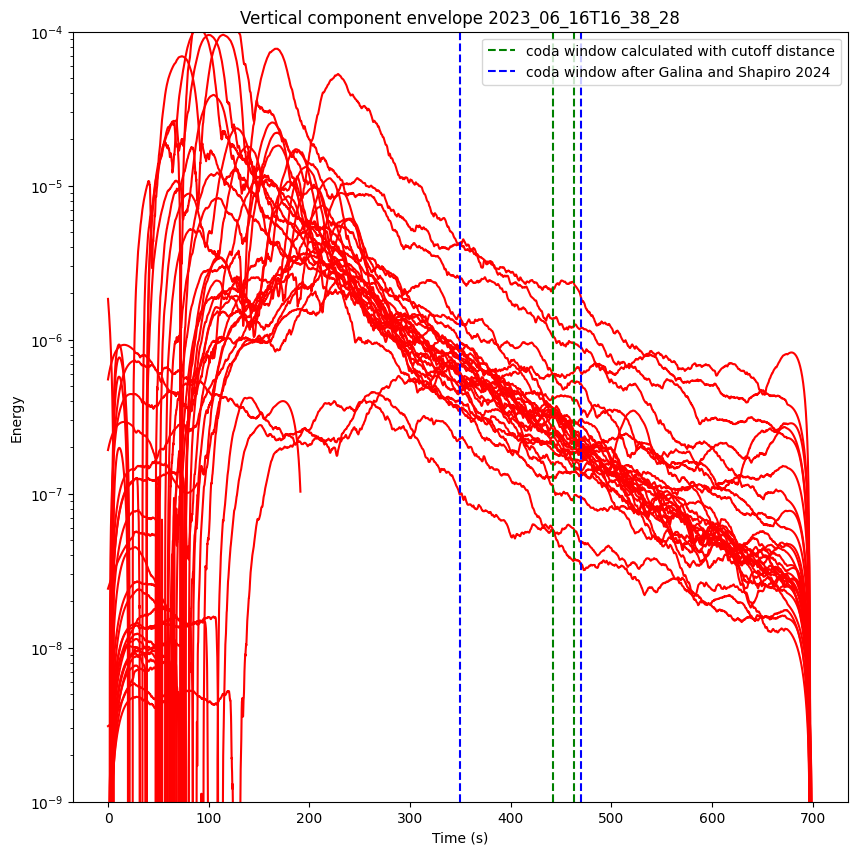

In [15]:
from scipy.signal import savgol_filter
from random import randint
def smooth_plot_envelope(time_string, n_traces,st_envelope):
    testing = [(randint(1, len(st_plot_filt_all))) for i in range(n_traces)]

    plt.figure(figsize=(10,10))
    for i in testing:
        if i < len(st_envelope):
            npts = len(st_envelope[i].data)
            samprate = st_envelope[i].stats.sampling_rate #10000/700 
            t = np.arange(0, npts / samprate, 1 / samprate)

            #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
            
            window_length = min(50*samprate, npts) # Ensure window_length is not greater than npts
            if window_length % 2 == 0:
                window_length -= 1
            yhat = savgol_filter(st_envelope[i].data, int(window_length), 3) 
            t = t[:len(yhat)]

            #plt.semilogy(t,st_envelope[i])
            plt.semilogy(t,yhat, color='red')
            plt.ylim([1e-9,1e-4])
            plt.title(f"Vertical component envelope {time_string}")
            plt.ylabel("Energy")
            plt.xlabel("Time (s)")
            #plt.xlim([100,350])
    plt.vlines(442.5923911439157,ymax=1e-4,ymin=1e-9, label='coda window calculated with cutoff distance',colors='g',linestyles='--')
    plt.vlines(462.5923911439157,ymax=1e-4,ymin=1e-9,colors='g',linestyles='--')
    plt.vlines(350,ymax=1e-4,ymin=1e-9, label='coda window after Galina and Shapiro 2024',colors='b',linestyles='--')
    plt.vlines(470,ymax=1e-4,ymin=1e-9,colors='b',linestyles='--')
    plt.legend()
    plt.show()

    return  
tset = smooth_plot_envelope(time_string, 50,st_envelope)

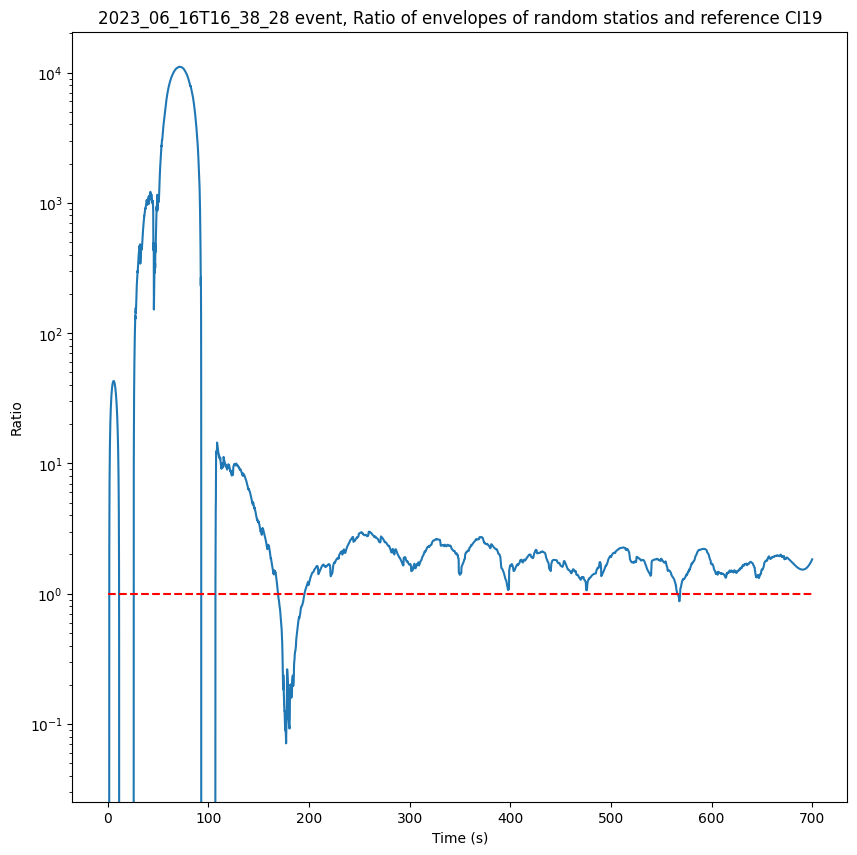

In [13]:
plt.figure(figsize=(10,10))
plt.semilogy(np.arange(0,700,0.01),savgol_filter(np.divide(resample(st_envelope[78].data,70000),resample(st_envelope[1].data,70000)),5000,3))
plt.title(f"{time_string} event, Ratio of envelopes of random statios and reference CI19")
plt.xlabel('Time (s)')
plt.ylabel('Ratio')
plt.hlines(1,xmin=0,xmax=700, linestyles="--",colors='r')

#### Routine
Now implement a routine, which, for a given event, gets the data, filters it, calculates the envelope for each trace and writes it in a stream. Then a second stream is initialised, where all the envelopes are smoothed. These streams can be written to disk. Plot the coda amplitude ratio (from disk) of all stations in relation to the same station, and the envelope ratio with the same ratio against each other. Then plot the coda amp ratio of a specific ratio over magnitudes. 

For the amplitude ratios, choose a time window of length 120s, then calculate the amplitude ratio and its mean.

In [ ]:
import numpy as np
import obspy
from scipy.signal import savgol_filter

def envelopes_routine(event, st_envelope, ref_idx, codastart=350, codaend=470, plotting=False, n_traces=50):
    st_envelope_smooth = obspy.Stream()
    
    # Iterate over all traces in st_envelope
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate  # Example: 10000/700
        t = np.arange(0, npts / samprate, 1 / samprate)

        # Define stable window length
        window_length = min(50 * samprate, npts)  # Ensure window_length is not greater than npts
        if window_length % 2 == 0:
            window_length -= 1
        
        # Smooth the envelope using Savitzky-Golay filter
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        # Create a new Trace with smoothed data
        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    # Calculate mean amplitude ratio
    station_ratio_amps = np.zeros((2, len(st_envelope_smooth)))

    for j, trace in enumerate(st_envelope_smooth):
        dt = trace.stats.delta
        startcoda = int(codastart / dt)  # Convert time to sample index
        endcoda = int(codaend / dt)      # Convert time to sample index

        # Ensure indices are within bounds
        if startcoda >= len(trace.data) or endcoda > len(trace.data):
            continue
        
        # Extract coda window
        coda = trace.data[startcoda:endcoda]
        ref = st_envelope_smooth[ref_idx].data[startcoda:endcoda]

        # Compute mean amplitude ratio
        station_ratio_amps[0, j] = j  # Storing index instead of station name
        station_ratio_amps[1, j] = (np.sqrt(np.dot(coda, coda.T)) / len(coda)) / \
                                   (np.sqrt(np.dot(ref, ref.T)) / len(ref))

    return station_ratio_amps

test = envelopes_routine(time_string, st_envelope, ref_idx=1, plotting=False)
print(test)


[[0.00000000e+00 1.00000000e+00 2.00000000e+00 ... 4.98000000e+02
  4.99000000e+02 5.00000000e+02]
 [9.57476895e-01 1.00000000e+00 1.06327764e+00 ... 4.34783680e-02
  3.50313761e-02 1.82552785e-02]]


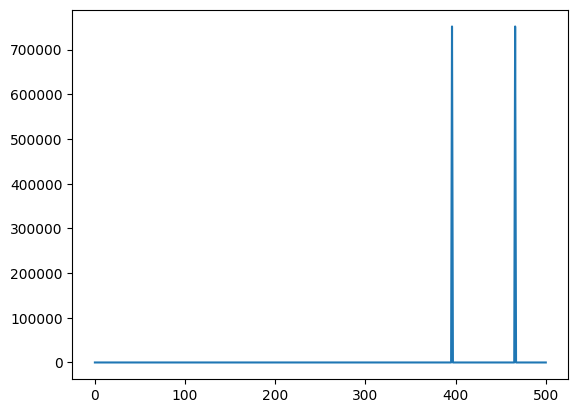

In [41]:

#plt.hist(test[:][1])
#plt.xlim([0,20])
plt.plot(test[:][1])